In [26]:
from psg import PSG
import matplotlib.pyplot as plt
from importlib import reload
import numpy as np
import pandas as pd
import constants
from ecg import ECG
from emg import EMG
import eeg
from eeg import EEG
from eog import EOG
from sao2 import *
from matplotlib import pyplot as plt
from scipy import stats
import gc
import sklearn as sk
from sklearn import impute as skImpute
import seaborn as sns
from sklearn import preprocessing
from sklearn import metrics
from sklearn import neighbors
from sklearn import mixture
from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
from scipy import stats
from sklearn import cluster
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from sklearn.metrics import classification_report

In [2]:
trainingData = ['nfle10', 'nfle11', 'nfle12', 'nfle13', 'nfle14', 'nfle15','plm10', 'plm1', 'plm2', 'plm3', 'plm5', 'plm6','rbd10', 'rbd11', 'rbd12', 'rbd13', 'rbd16', 'rbd17', 'ins2', 'ins6', 'n11', 'n2']
testingData = ['ins8', 'ins9', 'n5','nfle16', 'nfle17', 'nfle18', 'nfle19','plm7', 'plm8', 'plm9','rbd18', 'rbd19', 'rbd20']
allData = ['nfle10', 'nfle11', 'nfle12', 'nfle13', 'nfle14', 'nfle15', 'nfle16', 'nfle17', 'nfle18', 'nfle19', 
           'plm10', 'plm1', 'plm2', 'plm3', 'plm5', 'plm6', 'plm7', 'plm8', 'plm9', 'rbd10', 'rbd11', 'rbd12', 'rbd13', 
           'rbd16', 'rbd17', 'rbd18', 'rbd19', 'rbd20', 'ins2', 'ins6', 'ins8', 'ins9', 'n11', 'n2', 'n3', 'n5']
firstNumericCol = 6 # Includes age
filepath = 'final_data/'

final = pd.DataFrame()

for dataset in allData: # Stuff in the loop is done on each dataset individually before combining
    thisData = pd.read_csv(filepath + dataset + '.csv') # Create an untracked local data folder
    column_names = thisData.columns[firstNumericCol - 1:]

    # Add a patient column based on the file name so can be used to do groupby operations
    thisData.insert(1, "Patient", dataset)

    # Truncate based on shortest column before NaN's:
    lastNonNaNEachCol = thisData.notna()[::-1].idxmax()
    thisData = thisData.truncate(after = min(lastNonNaNEachCol))
    
    # Fill in missing data using KNN
    impute_KNN = thisData.iloc[:, firstNumericCol:]
    imputer = skImpute.KNNImputer(n_neighbors = 4, weights = "uniform")
    thisData.iloc[:, firstNumericCol:] = imputer.fit_transform(impute_KNN)

    # Combine with full dataset
    if final.empty:
        final = thisData
    else:
        final = pd.concat([final, thisData])
    
# Drop current "_norm" cols:
for col in final.columns:
    if "_norm" in col:
        final.drop(col, axis=1, inplace=True)

# Normalize (Divide by average within same patient):
for patient in final["Patient"].unique():
    thisPatientMeans = final[final["Patient"] == patient].iloc[:, firstNumericCol:].mean()
    final[final["Patient"] == patient].iloc[:, firstNumericCol:] -= thisPatientMeans
    
#Box-Cox
for column in final.columns[firstNumericCol:]:
    try:
        final[column] = final[column].abs()
        box_cox_trans = stats.boxcox(final[column])[0]
        final[column] = box_cox_trans
    except:
        continue
    #normalized = ((box_cox_trans-box_cox_trans.mean())/box_cox_trans.std())
    #final[column] = (box_cox_trans-box_cox_trans.min())/(box_cox_trans.max()-box_cox_trans.min())
    
print("Box-Cox completed.")  

#Robust Scaling
subset1 = final.iloc[:,:firstNumericCol]
subset2 = final.iloc[:,firstNumericCol:]

scaler = preprocessing.RobustScaler() # By default, centers and scales
robust_df = scaler.fit_transform(subset2)
final.iloc[:, firstNumericCol:] = robust_df
#robust_df = pd.DataFrame(robust_df, columns = column_names)
print("Robust Scaling completed.")

# Outlier Removal (Local Outlier Factor)
#keep_outliers = ['EMG']
n_neighbors = 20
LOF = neighbors.LocalOutlierFactor(n_neighbors = 20)
LOF.fit_predict(final.iloc[:, firstNumericCol:])
lof_factors = LOF.negative_outlier_factor_
final['lof'] = lof_factors
#outlierCutoff = -1000
quartiles = final['lof'].abs().quantile([0.25, 0.75])
#print(quartiles)
interQuartileRange = quartiles[0.75] - quartiles[0.25]
#outlierCutoff = -1 * (quartiles[0.75] + 1.5 * interQuartileRange)
outlierCutoff = -1000
outliers = final[final['lof'] <= outlierCutoff]
final = final[final['lof'] > outlierCutoff]
display(outliers)
#print(outlierCutoff)
#pd.DataFrame(lof_factors).to_csv('lof.csv')


#Encoding (Sleep Stage)
final.drop("Unnamed: 0", axis=1, inplace=True)

final.insert(2, "sleep_stage", np.zeros(len(final)))

for stage in constants.SLEEP_STAGES:
    final.loc[final["Sleep Stage"] == stage, "sleep_stage"] = constants.SLEEP_STAGES.get(stage)

final.drop("Sleep Stage", axis=1, inplace=True)

# Encoding (Condition)
conditionColumns = pd.DataFrame()
for patient in pd.unique(final['Patient']):
    thisPatientSeries = (final[final['Patient'] == patient])["condition"]
    thisPatientDf = thisPatientSeries.to_frame("condition")
    for condition in constants.CONDITION_TO_BINARY:
        if condition == thisPatientDf.at[0, 'condition']:
            binary = constants.CONDITION_TO_BINARY.get(condition)

            if binary[0] == 0:
                thisPatientDf.insert(1, "condition_0", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(1, "condition_0", np.ones(len(thisPatientDf)))

            if binary[1] == 0:
                thisPatientDf.insert(2, "condition_1", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(2, "condition_1", np.ones(len(thisPatientDf)))

            if binary[2] == 0:
                thisPatientDf.insert(3, "condition_2", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(3, "condition_2", np.ones(len(thisPatientDf)))

            if binary[3] == 0:
                thisPatientDf.insert(4, "condition_3", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(4, "condition_3", np.ones(len(thisPatientDf)))
    
    if conditionColumns.empty:
        conditionColumns = thisPatientDf[["condition_0", "condition_1", "condition_2", "condition_3"]]
    else: # ConditionColumns already initialized
        conditionColumns = pd.concat([conditionColumns, thisPatientDf[["condition_0", "condition_1", "condition_2", "condition_3"]]])
final.insert(5, "rbd", conditionColumns["condition_0"])
final.insert(6, "ins", conditionColumns["condition_1"])
final.insert(7, "nfle", conditionColumns["condition_2"])
final.insert(8, "plm", conditionColumns["condition_3"])

final.drop("condition", axis=1, inplace=True)

print('Encoding completed.')


#Robust Scaling
#subset1 = final.iloc[:,:firstNumericCol]
#subset2 = final.iloc[:,firstNumericCol:]

#scaler = preprocessing.RobustScaler() # By default, centers and scales
#robust_df = scaler.fit_transform(subset2)
#robust_df = pd.DataFrame(robust_df, columns = column_names)
#print("Robust Scaling done for " + dataset)

#Export
#final = pd.concat([subset1, robust_df], axis = 1)
final.reset_index(inplace=True)
final = final.iloc[:,1:]
final.to_csv('final.csv')
print('Dataset successfully exported!')

/Users/josh/opt/miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1851: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Box-Cox completed.
Robust Scaling completed.


,Unnamed: 0,Patient,epoch,Sleep Stage,condition,gender,age,beta_relative_power,alpha_relative_power,theta_relative_power,...,hf_ECG1-ECG2,lf/hf_ECG1-ECG2,breathingrate_ECG1-ECG2,bpm_PLETH,rmssd_PLETH,lf_PLETH,hf_PLETH,lf/hf_PLETH,breathingrate_PLETH,lof
374,374,nfle10,374,R,Nocturnal Frontal Lobe Epilepsy,M,-1.226634,0.861127,-0.106323,-0.200780,...,1.206724e+44,-0.217233,-0.333333,0.230308,-0.769933,-8.044957e-02,-4.261779e-01,0.580927,-0.333333,-4.726525e+12
387,387,nfle10,387,R,Nocturnal Frontal Lobe Epilepsy,M,-1.226634,0.361742,0.026538,-0.056699,...,1.456903e+00,-0.238898,-0.333333,0.142725,-0.891205,8.043760e+41,7.393874e+41,0.156227,-0.666667,-1.342836e+10
218,218,nfle11,218,S4,Nocturnal Frontal Lobe Epilepsy,M,-0.871179,0.164300,-0.289261,-0.037130,...,1.887464e+27,-0.168941,-0.333333,0.458659,-0.316816,-1.937387e-01,-1.486257e-01,-0.097662,1.333333,-7.149315e+04
278,278,nfle11,278,S2,Nocturnal Frontal Lobe Epilepsy,M,-0.871179,1.281765,0.227393,-0.161137,...,1.674266e+30,-0.233286,0.666667,0.634031,-0.185051,6.586959e-01,-3.520297e-02,0.764468,-2.333333,-1.327825e+07
958,958,nfle12,958,R,Nocturnal Frontal Lobe Epilepsy,F,0.320179,0.843859,0.991950,0.438805,...,1.031628e+21,969.021791,-0.311804,-1.155606,-1.097688,-1.158495e-02,3.008907e+00,-0.780868,-2.333333,-2.023685e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,326,n5,326,R,Normal,F,-0.752073,0.020202,-0.343748,0.627355,...,1.505090e+40,8483.177750,-0.741927,-0.252513,0.340828,5.501909e-01,6.794358e-01,-0.073722,-0.666667,-2.746749e+12
331,331,n5,331,R,Normal,F,-0.752073,-0.020733,-0.406724,0.271582,...,1.075065e+39,531.619230,0.202554,-0.286485,0.324813,5.960533e-01,9.377940e-01,-0.175537,1.000000,-2.487703e+14
332,332,n5,332,R,Normal,F,-0.752073,-0.081796,-0.474104,0.267602,...,1.254242e+39,564.877067,0.316467,-0.291897,0.326164,6.114174e-01,1.473437e+00,-0.353675,1.000000,-2.799106e+14
333,333,n5,333,R,Normal,F,-0.752073,0.079453,-0.398121,0.375879,...,1.505090e+39,645.646099,0.483767,-0.285295,0.309032,4.608818e-01,1.602134e+00,-0.450168,0.000000,-3.235109e+14


Encoding completed.
Dataset successfully exported!


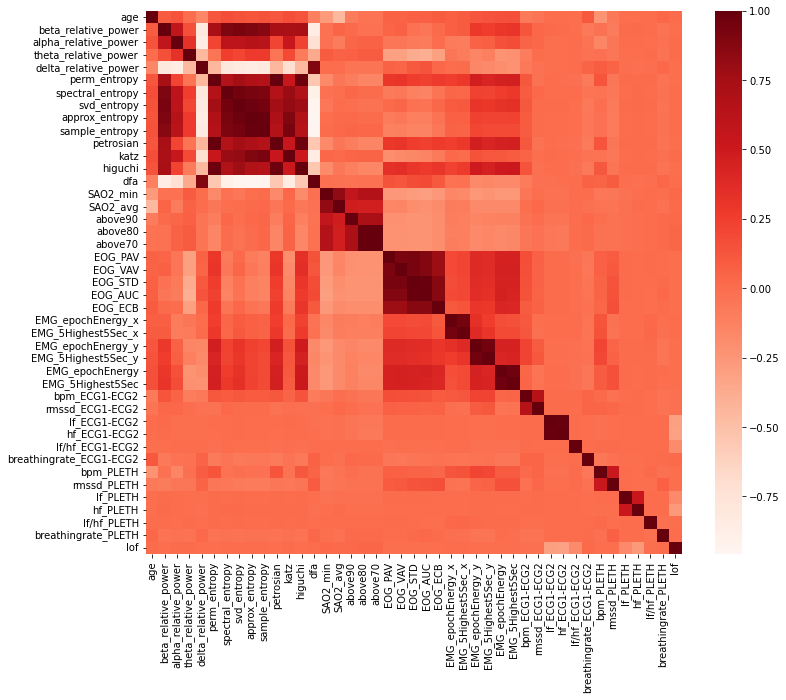

<ipython-input-3-5fd55964c2aa>:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lowerTriangleMask = np.tril(np.ones(cor.shape), -1).astype(np.bool) # Create lower triangle mask


                Feature A             Feature B      Corr
50              petrosian          perm_entropy  0.999822
170               above70               above80  0.997975
44         sample_entropy        approx_entropy  0.989703
560          hf_ECG1-ECG2          lf_ECG1-ECG2  0.988914
252               EOG_AUC               EOG_STD  0.986746
76                higuchi             petrosian  0.974166
71                higuchi          perm_entropy  0.971782
35         approx_entropy           svd_entropy  0.970886
434      EMG_5Highest5Sec       EMG_epochEnergy  0.968907
377    EMG_5Highest5Sec_y     EMG_epochEnergy_y  0.958228
86                    dfa        approx_entropy  0.957961
27            svd_entropy      spectral_entropy  0.954423
324    EMG_5Highest5Sec_x     EMG_epochEnergy_x  0.950446
87                    dfa        sample_entropy  0.943353
43         sample_entropy           svd_entropy  0.941832
85                    dfa           svd_entropy  0.939872
34         app

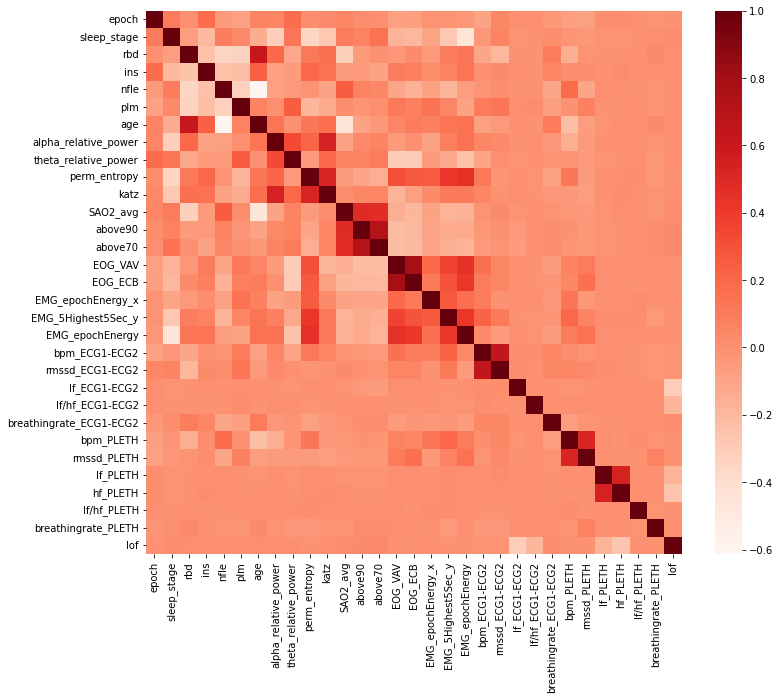

In [3]:
# Feature Removal Based on Between-Feature Correlation:

## INPUTS ##:
threshold = 0.8 # Abs correlation above which feature is removed

# 1. Calculate Correlation Matrix of the Predictors
columnsToCorr = list(final.columns)
safeFeatures = ['Patient', 'epoch', 'sleep_stage', 'rbd', 'ins', 'nfle', 'plm'] # Features that we won't remove
for i in safeFeatures:
    columnsToCorr.remove(i)

plt.figure(figsize=(12,10))
cor = final[columnsToCorr].corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

# 2. Determine the two predictors associated with the largest absolute pairwise correlation
# Remove (set = 0) half of the matrix because symmetric:
lowerTriangleMask = np.tril(np.ones(cor.shape), -1).astype(np.bool) # Create lower triangle mask
corLowerTriangle = cor.where(lowerTriangleMask)
corAbs = corLowerTriangle.abs() # Consider absolute correlation

# Build sorted dataframe of form: ["Feature A", "Feature B", corr]
pairwiseCorr = corAbs.stack().reset_index()
pairwiseCorr.columns = ['Feature A','Feature B','Corr']

# Isolate correlations to remove
pairwiseCorr = pairwiseCorr[pairwiseCorr['Corr'] > threshold]
pairwiseCorr.sort_values('Corr', ascending = False, inplace = True)
print(pairwiseCorr)

# 3. Determine the average correlation between A and B and every other feature:
# Create an average correlation dataframe of form [feature, averageCorr]
averageCorr = pd.DataFrame(cor.abs().mean(axis = 1), cor.index, ['avgCorr'])

# Loop through pairwiseCorr, make a list of features to remove. 
featuresToRemove = []
for index, row in pairwiseCorr.iterrows():
    featureA = row['Feature A']
    featureB = row['Feature B']
    featureA_avgCorr = averageCorr.loc[featureA, 'avgCorr']
    featureB_avgCorr = averageCorr.loc[featureB, 'avgCorr']

    # If A has larger average correlation, remove it. Otherwise, remove B
    if featureA_avgCorr >= featureB_avgCorr:
        if featureA not in featuresToRemove:
            featuresToRemove.append(featureA)
    else:
        if featureB not in featuresToRemove:
            featuresToRemove.append(featureB)

# Report results:
print("Threshold: " + str(threshold))
print(featuresToRemove)

# Dataset with features removed
correlationFeatureRemoval = final.drop(featuresToRemove, axis = 1)
print("Remaining Features: " + str(correlationFeatureRemoval.shape[1]))
correlationFeatureRemoval.to_csv('finalTesting.csv')
# Show the correlation matrix after feature removal
plt.figure(figsize=(12,10))
cor2 = correlationFeatureRemoval.corr()
sns.heatmap(cor2, annot=False, cmap=plt.cm.Reds)
plt.show()

In [11]:
finalData = pd.read_csv('final.csv')
correlationFeatureRemoval = finalData
# Feature Selection with Mutual Information

info_selection = pd.concat([correlationFeatureRemoval['sleep_stage'], correlationFeatureRemoval.iloc[:, 9:]], axis=1)

safe_features = list(correlationFeatureRemoval.iloc[:, :9].columns)

info_scores = []

for x in info_selection.columns[1:]:
    score = metrics.normalized_mutual_info_score(info_selection['sleep_stage'], info_selection[x])
    column_and_score = (x, score)
    info_scores.append(column_and_score)
    
target_columnscore = pd.DataFrame(info_scores).sort_values(by=1, ascending = False)

top_5_cols = safe_features+list(target_columnscore[0][:5])
top_10_cols = safe_features+list(target_columnscore[0][:10])
top_20_cols = safe_features+list(target_columnscore[0][:20])
top_30_cols = safe_features+list(target_columnscore[0][:30])

top_5_data = correlationFeatureRemoval[top_5_cols]
top_10_data = correlationFeatureRemoval[top_10_cols]
top_20_data = correlationFeatureRemoval[top_20_cols]
top_30_data = correlationFeatureRemoval[top_30_cols]

print(target_columnscore)

/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous 

                          0         1
21                  EOG_STD  0.272477
22                  EOG_AUC  0.272477
23                  EOG_ECB  0.272477
26        EMG_epochEnergy_y  0.272477
27       EMG_5Highest5Sec_y  0.272477
28          EMG_epochEnergy  0.272477
29         EMG_5Highest5Sec  0.272477
13                      dfa  0.272477
12                  higuchi  0.272477
1       beta_relative_power  0.272477
8            approx_entropy  0.272477
7               svd_entropy  0.272477
6          spectral_entropy  0.272477
5              perm_entropy  0.272477
4      delta_relative_power  0.272477
3      theta_relative_power  0.272477
2      alpha_relative_power  0.272477
10                petrosian  0.272477
9            sample_entropy  0.272477
11                     katz  0.272477
24        EMG_epochEnergy_x  0.272469
25       EMG_5Highest5Sec_x  0.272469
42                      lof  0.272442
37              rmssd_PLETH  0.272423
39                 hf_PLETH  0.271954
36          

/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous 

In [44]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes 
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size 
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, bidirectional=False) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.drop = nn.Dropout(p=0.2)
        
    def forward(self,x):
        # hidden state
        
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # cell state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.sigmoid(out)
        out = self.fc_2(out) # final output
        out = self.drop(out)
        
        return out

In [40]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    numFeatures = X_train.shape[1]
    print("Top "+ str(numFeatures) + " LSTM")
    
    train_loss_values = []
    test_loss_values = []
    final_preds = 0
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        train_loss_values.append(loss.item())
        optimiser.step() #backpropagation
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        if (epoch == (n_epochs - 1)):
            final_preds = test_preds
        test_loss = loss_fn(test_preds, y_test)
        test_loss_values.append(test_loss.item())
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item()))
    
    return train_loss_values, test_loss_values, final_preds

In [21]:
def dimReduction(dataToReduce, type = "PCA", n_components = 2, perplexity = 30, n_iters = 1000, simplifiedTarget = False):
    data = dataToReduce.iloc[:,8:].to_numpy()
    target = dataToReduce.loc[:, "sleep_stage"].to_numpy()
    if type == "PCA":
        model = PCA(n_components = n_components)
        data_reduced = model.fit_transform(data)
    elif type == "TSNE":
        model = TSNE(n_components = n_components, perplexity = perplexity, n_iter = n_iters)
        data_reduced = model.fit_transform(data)
    elif type == "Isomap":
        # Isomap:
        model = manifold.Isomap(n_neighbors = 12, n_components = n_components)
        model.fit(data)
        data_reduced = model.transform(data)

    if simplifiedTarget:
        simplifiedTarget = []
        for i in target:
            if i >= 1.0 and i <= 4.0:
                simplifiedTarget.append(1.0)
            elif i == 5.0:
                simplifiedTarget.append(2.0)
            else:
                simplifiedTarget.append(0.0)
        target = np.array(simplifiedTarget)

    return data_reduced, target

In [22]:
# Function for Plotting PSA, TSNE, or Clusters:
def plot_dimReduction(dataToPlot, label, label_meaning = "target", scaleFactors = [1, 1, 1], eliv = None, azim = None):
    cols = np.shape(dataToPlot)[1]
    if cols == 1:
        # 1D Plot
        #sf = 10**49
        sf = scaleFactors[0]
        df_reduced = pd.DataFrame(dataToPlot / sf, columns=["pca_feature_1"])
        df_reduced[label_meaning] = label

        # Creating dataset
        np.random.seed(10)
        
        data_0 = df_reduced.loc[df_reduced[label_meaning] == 0, "pca_feature_1"]
        data_1 = df_reduced.loc[df_reduced[label_meaning] == 1, "pca_feature_1"]
        data_2 = df_reduced.loc[df_reduced[label_meaning] == 2, "pca_feature_1"]
        data_3 = df_reduced.loc[df_reduced[label_meaning] == 3, "pca_feature_1"]
        data_4 = df_reduced.loc[df_reduced[label_meaning] == 4, "pca_feature_1"]
        data_5 = df_reduced.loc[df_reduced[label_meaning] == 5, "pca_feature_1"]
        data = [data_0, data_1, data_2, data_3, data_4, data_5]
        
        fig = plt.figure(figsize=(10,5))
        
        # Configure axes
        ax = fig.add_axes([0, 0, 1, 1])
        ax.set_xticklabels(['0', '1', '2', '3', '4', '5'])
        plt.xlabel("sleep_stage")
        plt.ylabel("feature_1")
        
        # Creating plot (handles outliers)
        bp = ax.boxplot(data, showfliers=False)  

        # show plot
        plt.show()

    elif cols == 2:
        # Dataframe
        df_reduced = pd.DataFrame(dataToPlot, columns=["feature_1", "feature_2"])
        df_reduced[label_meaning] = label

        # Outlier Removal
        original_rows = len(df_reduced)
        df_reduced = df_reduced[(np.abs(stats.zscore(df_reduced)) < 3.5).all(axis=1)]
        print("Number of Outliers Removed: " + str(original_rows - len(df_reduced)))

        # Optional Code to Correctly Scale/Reduce
        #df_reduced = df_reduced[df_reduced["feature_1"] < 0]

        # 2D Plot
        fig = plt.figure(figsize=(10,10))
        sns.scatterplot(data=df_reduced, x="feature_1", y="feature_2", hue=label_meaning, palette="deep")

        fig.show()

    elif cols == 3:
        # Dataframe
        df_reduced = pd.DataFrame(dataToPlot, columns=["feature_1", "feature_2", "feature_3"])
        df_reduced[label_meaning] = label
        # Outlier Removal
        original_rows = len(df_reduced)
        df_reduced = df_reduced[(np.abs(stats.zscore(df_reduced)) < 3.5).all(axis=1)]
        print("Number of Outliers Removed: " + str(original_rows - len(df_reduced)))

        # Optional Scaling Factor
        #sf_x = 10**45
        sf_x = scaleFactors[0]
        sf_y = scaleFactors[1]
        sf_z = scaleFactors[2]

        # 3D Plot
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection = '3d')
        cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
        sc = ax.scatter(xs=df_reduced["feature_1"] / sf_x, ys=df_reduced["feature_2"] / sf_y, zs=df_reduced["feature_3"] / sf_z, c=df_reduced[label_meaning], cmap=cmap)
        if eliv and azim:
            ax.view_init(eliv, azim)

        # Axes
        ax.set_xlabel('feature_1')
        ax.set_ylabel('feature_2')
        ax.set_zlabel('feature_3')

        # Legend
        plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

        # Optional Scaling
        # plt.xlim([-1.2554, -1.2548])

        plt.show()
        
        

In [23]:
trainingDatainds = ['ins2', 'ins6', 'n11', 'n2', 'nfle10', 'nfle11', 'nfle12', 'nfle13', 'nfle14', 'nfle15', 
                'plm10', 'plm1', 'plm2', 'plm3', 'plm5', 'plm6', 'rbd10', 'rbd11', 'rbd12', 'rbd13', 'rbd16', 'rbd17']

testingDatainds = ['ins8', 'ins9', 'n3', 'n5', 'nfle16', 'nfle17', 'nfle18', 'nfle19', 'plm7', 'plm8', 'plm9', 
               'rbd18', 'rbd19', 'rbd20']

/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
<ipython-input-24-d166359da9f3>:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  reduced_train = reduced[[top_5_data['Patient'].isin(trainingDatainds)]]
<ipython-input-24-d166359da9f3>:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

Number of Outliers Removed: 0
Number of Outliers Removed: 0


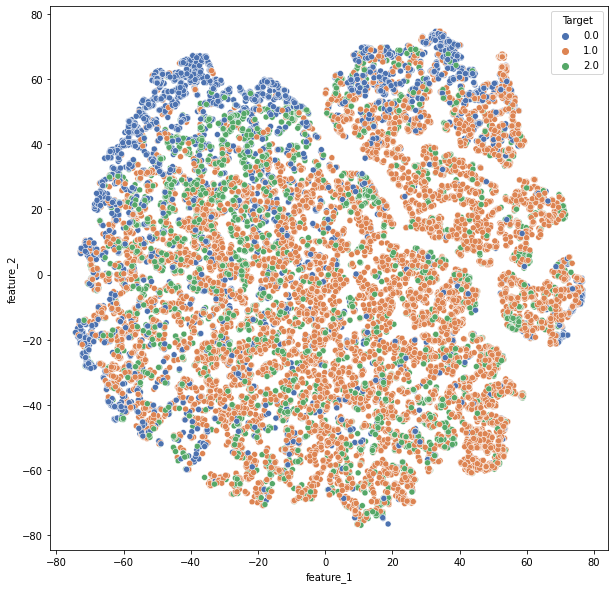

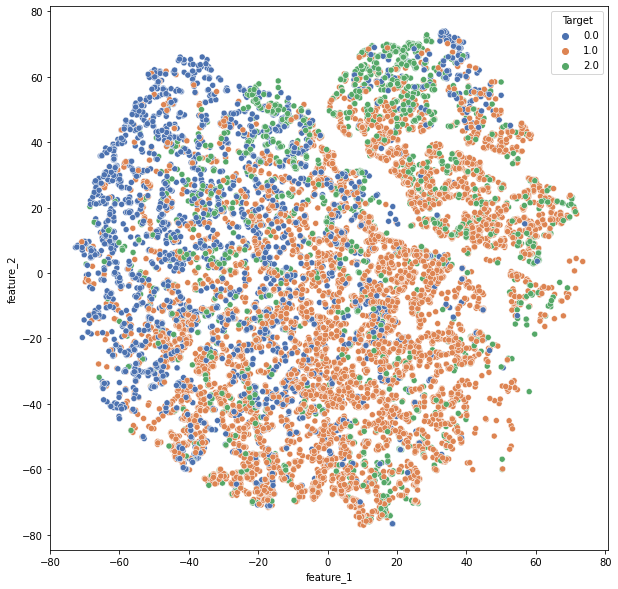

In [24]:
reduced, reduced_target = dimReduction(top_5_data, type = 'TSNE', n_components = 2, perplexity = 30, simplifiedTarget = True)
reduced_train = reduced[[top_5_data['Patient'].isin(trainingDatainds)]]
reduced_train_target = reduced_target[[top_5_data['Patient'].isin(trainingDatainds)]]

reduced_test = reduced[[top_5_data['Patient'].isin(testingDatainds)]]
reduced_test_target = reduced_target[[top_5_data['Patient'].isin(testingDatainds)]]

plot_dimReduction(reduced_train, reduced_train_target, label_meaning = "Target", scaleFactors = [1, 1, 1])
plot_dimReduction(reduced_test, reduced_test_target, label_meaning = "Target", scaleFactors = [1, 1, 1])

In [31]:
print(reduced_train)

[[-39.649055   -3.624906 ]
 [-40.845375   48.1225   ]
 [-31.38688    53.58624  ]
 ...
 [ -3.105286  -20.77594  ]
 [  0.4934635 -46.651733 ]
 [-16.109512  -38.34929  ]]


/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
<ipython-input-53-473abcca7788>:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  reduced_train = reduced[[top_10_data['Patient'].isin(trainingDatainds)]]
<ipython-input-53-473abcca7788>:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `a

Number of Outliers Removed: 0
Number of Outliers Removed: 0


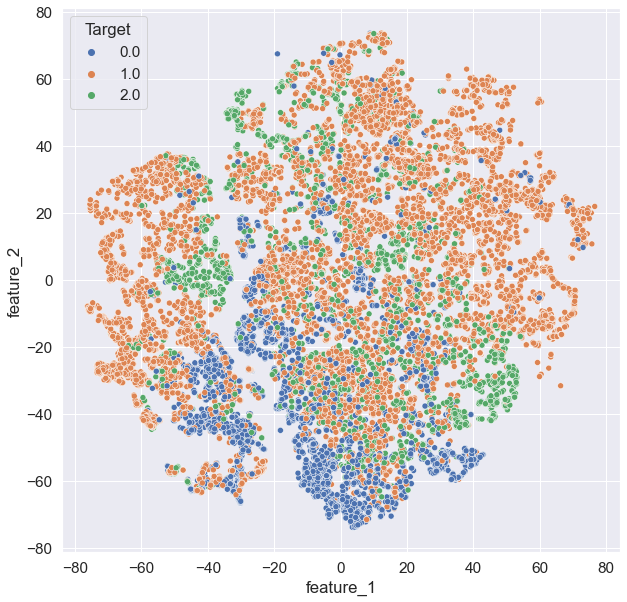

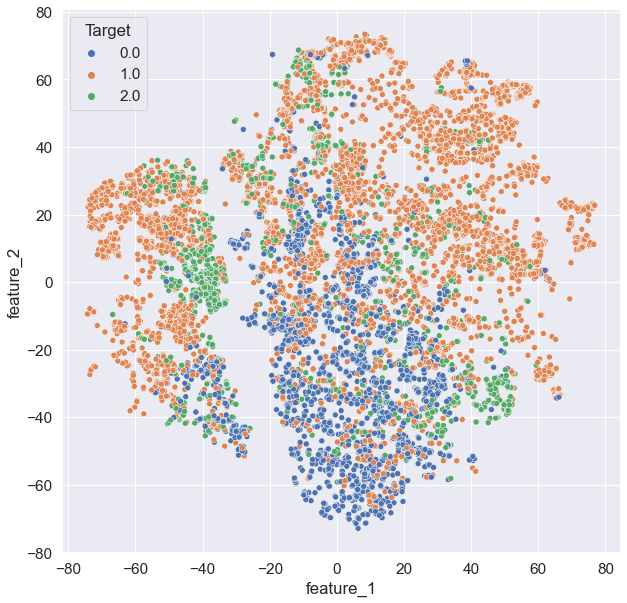

In [53]:
reduced, reduced_target = dimReduction(top_10_data, type = 'TSNE', n_components = 2, perplexity = 30, simplifiedTarget = True)
reduced_train = reduced[[top_10_data['Patient'].isin(trainingDatainds)]]
reduced_train_target = reduced_target[[top_10_data['Patient'].isin(trainingDatainds)]]

reduced_test = reduced[[top_10_data['Patient'].isin(testingDatainds)]]
reduced_test_target = reduced_target[[top_10_data['Patient'].isin(testingDatainds)]]

plot_dimReduction(reduced_train, reduced_train_target, label_meaning = "Target", scaleFactors = [1, 1, 1])
plot_dimReduction(reduced_test, reduced_test_target, label_meaning = "Target", scaleFactors = [1, 1, 1])

In [54]:
print(reduced_train.shape)

(19591, 2)


Top 1 LSTM
Epoch: 0, train loss: 1.15107, test loss: 1.10056
Epoch: 100, train loss: 0.94078, test loss: 0.89896
Epoch: 200, train loss: 0.91773, test loss: 0.87390
Epoch: 300, train loss: 0.89779, test loss: 0.85570
Epoch: 400, train loss: 0.88424, test loss: 0.84365
Epoch: 500, train loss: 0.87021, test loss: 0.83861
Epoch: 600, train loss: 0.86265, test loss: 0.83391
Epoch: 700, train loss: 0.86061, test loss: 0.83294
Epoch: 800, train loss: 0.85760, test loss: 0.83059
Epoch: 900, train loss: 0.85614, test loss: 0.82958


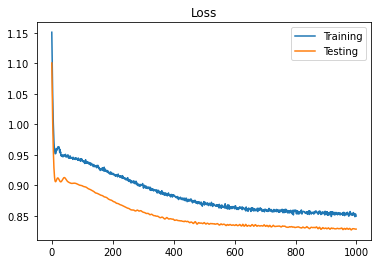

In [47]:
#Top 5
#Params
n_epochs = 1000
learning_rate = 0.001

input_size = 2 
hidden_size = 2 
num_layers = 1 

num_classes = 3 # 5+1 for unknown 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)
lstm = lstm.float()

loss_fn = torch.nn.CrossEntropyLoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

#Data
reduced_train = torch.tensor(reduced_train).float()
reduced_train_target = torch.tensor(reduced_train_target).float().type(torch.LongTensor)
reduced_test = torch.tensor(reduced_test).float()
reduced_test_target = torch.tensor(reduced_test_target).float().type(torch.LongTensor)


reduced_train = torch.reshape(reduced_train,(reduced_train.shape[0], 1, 
                                       reduced_train.shape[1])).float()

reduced_test = torch.reshape(reduced_test,(reduced_test.shape[0], 1, 
                                       reduced_test.shape[1])).float()



# print(test_target)

#Training Loop
trainLoss, testLoss, final_preds = training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=reduced_train,
              y_train=reduced_train_target,
              X_test=reduced_test,
              y_test=reduced_test_target)

plt.title('Loss')
plt.plot(trainLoss, label = 'Training')
plt.plot(testLoss, label = 'Testing')
plt.legend()




/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           W       0.52      0.30      0.39      2744
        NREM       0.70      0.96      0.81      7672
           R       0.00      0.00      0.00      1772

    accuracy                           0.67     12188
   macro avg       0.41      0.42      0.40     12188
weighted avg       0.56      0.67      0.59     12188



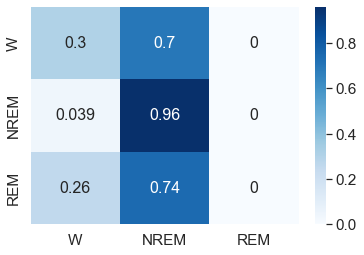

/Users/josh/opt/miniconda3/lib/python3.9/site-packages/pandas/core/internals/construction.py:540: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  values = np.array([convert(v) for v in values])
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/pandas/core/internals/construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) fo

AttributeError: 'torch.dtype' object has no attribute 'type'

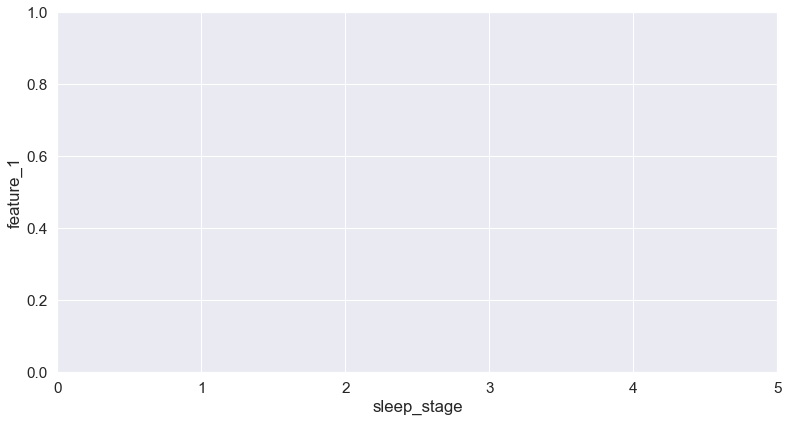

In [52]:
target_names = ['W', 'NREM', 'R']
print(classification_report(reduced_test_target.detach().numpy(), np.argmax(final_preds.detach().numpy(),1), target_names = target_names))

predicted_stages = np.argmax(final_preds.detach().numpy(),1)
conf = metrics.confusion_matrix(reduced_test_target, predicted_stages)
ind_accs = conf/(conf.sum(axis=1, keepdims=True))

df_cm = pd.DataFrame(ind_accs, index = ['W', 'NREM', 'REM'], columns = ['W', 'NREM', 'REM'])
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues") # font size
plt.show()

plot_dimReduction(reduced_test, predicted_stages, label_meaning = "Target", scaleFactors = [1, 1, 1])

Top 1 LSTM
Epoch: 0, train loss: 1.03366, test loss: 0.99082
Epoch: 100, train loss: 0.92623, test loss: 0.88966
Epoch: 200, train loss: 0.85735, test loss: 0.83266
Epoch: 300, train loss: 0.84532, test loss: 0.81565
Epoch: 400, train loss: 0.83676, test loss: 0.80423
Epoch: 500, train loss: 0.82957, test loss: 0.79747
Epoch: 600, train loss: 0.81590, test loss: 0.79983
Epoch: 700, train loss: 0.81668, test loss: 0.79930
Epoch: 800, train loss: 0.80195, test loss: 0.78329
Epoch: 900, train loss: 0.79433, test loss: 0.77786


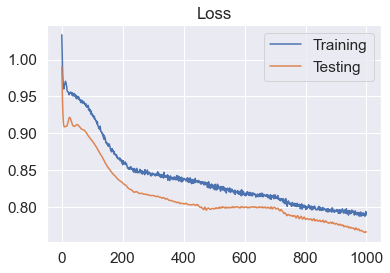

In [57]:
#Top 10
#Params
n_epochs = 1000
learning_rate = 0.001

input_size = 2
hidden_size = 2
num_layers = 1 

num_classes = 3 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)
lstm = lstm.float()

loss_fn = torch.nn.CrossEntropyLoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)


#Data
reduced_train = torch.tensor(reduced_train).float()
reduced_train_target = torch.tensor(reduced_train_target).float().type(torch.LongTensor)
reduced_test = torch.tensor(reduced_test).float()
reduced_test_target = torch.tensor(reduced_test_target).float().type(torch.LongTensor)


reduced_train = torch.reshape(reduced_train,(reduced_train.shape[0], 1, 
                                       reduced_train.shape[1])).float()

reduced_test = torch.reshape(reduced_test,(reduced_test.shape[0], 1, 
                                       reduced_test.shape[1])).float()

#Training Loop
trainLoss, testLoss, final_preds = training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=reduced_train,
              y_train=reduced_train_target,
              X_test=reduced_test,
              y_test=reduced_test_target)

plt.title('Loss')
plt.plot(trainLoss, label='Training')
plt.plot(testLoss, label='Testing')
plt.legend()

              precision    recall  f1-score   support

           W       0.70      0.38      0.49      2744
        NREM       0.69      0.96      0.80      7672
           R       0.00      0.00      0.00      1772

    accuracy                           0.69     12188
   macro avg       0.46      0.45      0.43     12188
weighted avg       0.59      0.69      0.62     12188



/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


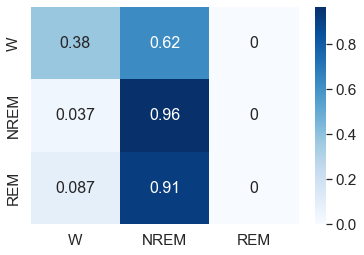

<ipython-input-22-ac8dce549690>:53: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Number of Outliers Removed: 0


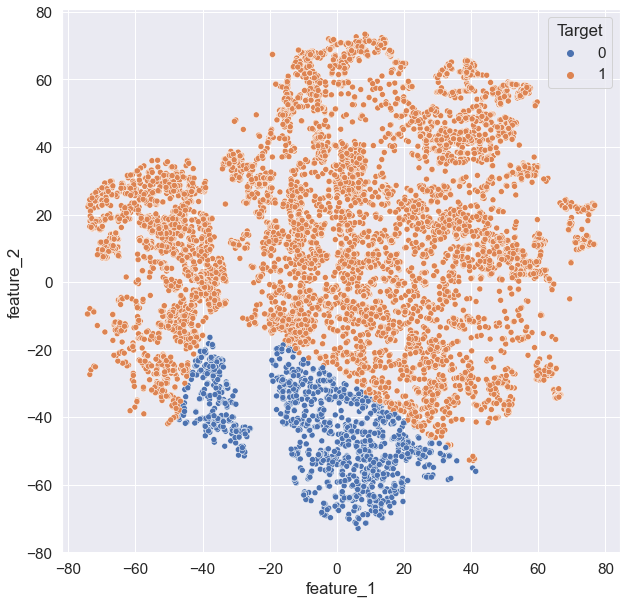

In [62]:
target_names = ['W', 'NREM', 'R']
print(classification_report(reduced_test_target.detach().numpy(), np.argmax(final_preds.detach().numpy(),1), target_names = target_names))

predicted_stages = np.argmax(final_preds.detach().numpy(),1)
conf = metrics.confusion_matrix(reduced_test_target, predicted_stages)
ind_accs = conf/(conf.sum(axis=1, keepdims=True))

df_cm = pd.DataFrame(ind_accs, index = ['W', 'NREM', 'REM'], columns = ['W', 'NREM', 'REM'])
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues") # font size
plt.show()

reduced_test = torch.reshape(reduced_test,(reduced_test.shape[0], 
                                       reduced_test.shape[2])).float()

plot_dimReduction(reduced_test.numpy(), predicted_stages, label_meaning = "Target", scaleFactors = [1, 1, 1])

Top 20 LSTM
Epoch: 0, train loss: 1.78213, test loss: 1.75811
Epoch: 100, train loss: 1.59632, test loss: 1.65432
Epoch: 200, train loss: 1.47639, test loss: 1.58158
Epoch: 300, train loss: 1.37877, test loss: 1.57220
Epoch: 400, train loss: 1.30114, test loss: 1.62873
Epoch: 500, train loss: 1.24658, test loss: 1.71337
Epoch: 600, train loss: 1.21838, test loss: 1.82486
Epoch: 700, train loss: 1.19516, test loss: 1.85627
Epoch: 800, train loss: 1.18208, test loss: 1.88652
Epoch: 900, train loss: 1.17411, test loss: 1.91067


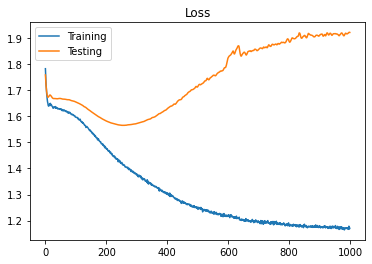

In [80]:
#Top 20
#Params
n_epochs = 1000
learning_rate = 0.001

input_size = 20
hidden_size = 2
num_layers = 1 

num_classes = 6 # 5+1 for unknown 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)
lstm = lstm.float()

loss_fn = torch.nn.CrossEntropyLoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

#Data
train_input = torch.tensor(top_20_dataTr.iloc[:,9:].to_numpy()).float()
train_target = torch.tensor(top_20_dataTr.iloc[:,3].to_numpy()).float().type(torch.LongTensor)
test_input = torch.tensor(top_20_dataTe.iloc[:,9:].to_numpy()).float()
test_target = torch.tensor(top_20_dataTe.iloc[:,3].to_numpy()).float().type(torch.LongTensor)


train_input = torch.reshape(train_input,(train_input.shape[0], 1, 
                                       train_input.shape[1])).float()

test_input = torch.reshape(test_input,(test_input.shape[0], 1, 
                                       test_input.shape[1])).float()

#Training Loop
trainLoss, testLoss, final_preds = training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=train_input,
              y_train=train_target,
              X_test=test_input,
              y_test=test_target)

plt.title('Loss')
plt.plot(trainLoss, label='Training')
plt.plot(testLoss, label='Testing')
plt.legend()

In [81]:
target_names = ['W', 'S1', 'S2', 'S3', 'S4', 'R']
print(classification_report(test_target.detach().numpy(), np.argmax(final_preds.detach().numpy(),1), target_names = target_names))

              precision    recall  f1-score   support

           W       0.65      0.53      0.58      2598
          S1       0.00      0.00      0.00       621
          S2       0.06      0.00      0.01      3545
          S3       0.00      0.00      0.00      1397
          S4       0.15      0.94      0.26      1400
           R       0.10      0.00      0.00      1579

    accuracy                           0.24     11140
   macro avg       0.16      0.25      0.14     11140
weighted avg       0.20      0.24      0.17     11140



/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
